## Import Libraries

In [37]:
>>> import nltk
>>> nltk.download('stopwords')
import pandas as pd
import json
import numpy as np
import re
from nltk.stem.porter import *
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn import model_selection,metrics,preprocessing
import torch
from torchtext import data
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import spacy
lang = spacy.load('en')
stemmer = PorterStemmer()
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

stemmer = PorterStemmer()
import warnings
warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("GPU Model   ",torch.cuda.get_device_name(0))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
GPU Model    Tesla T4


## Confusion Matrix Method

In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Loading Dataset and preProcessing Functions

In [39]:
def clean_data(X):
    STOPWORDS = set(stopwords.words('english'))
    X=X.str.lower()
    X=X.str.replace("[/(){}\[\]\|@,;]", " ")
    X=X.str.replace("[^0-9a-z #+_]", " ")
    X = X.str.replace(r'\d+','')
    X = X.apply(lambda x: ' '.join([w for w in str(x).split() if (len(w)>2 and w not in STOPWORDS) ] ))
    X = X.apply(lambda x: x.split()) 
    return X

def Preprocess(JsonFile,number_of_sector,text_Sector,Csvname):
    with open(JsonFile,"r") as fp:
    #with open("General_Market.json",encoding='utf8') as fp:
        json_d = json.load(fp)

    ticks_d = json_d['data']
    df = pd.DataFrame(ticks_d)

    X= pd.DataFrame(columns=['Article','Target'])
    X['Article']=df['title']+" "+df['text']
    X['Target']=number_of_sector




    print("Number of Examples in ",text_Sector," : ",len(X),"\n")
    X.drop_duplicates(inplace=True)
    X.index = range(len(X))
    print("Number of Examples after removing duplicates: ",len(X),"\n")

    print('Number of words before cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
    X['Article']=clean_data(X['Article'])
    print('Number of words after cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
    print("\n*****************************************************************************\n")
    
    X['Article']= X['Article'].apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
    for i in range(len(X['Article'])): #φέρνω τα tokens ξανά μαζί διαχωριζόμενα με κενά
        X['Article'][i] = ' '.join(X['Article'][i])
    
    #Xv = X['Article'].to_frame()
    X.to_csv (Csvname, index = False, header=True)


## Preprocessing

In [40]:
#Technology=0,Health=1,Financial=2,Consumer=3,Energy=4,Commodity=5

Preprocess('Technology_news.json',0,'Technology news','Technology.csv')
Preprocess('Health_news.json',1,'Health news','Health.csv')
Preprocess('Financial_news.json',2,'Financial news','Financial.csv')
Preprocess('Consumer_news.json',3,'Consumer news','Consumer.csv')
Preprocess('Energy_news.json',4,'Energy news','Energy.csv')
Preprocess('Commodity_news.json',5,'Commodity news','Commodity.csv')

Number of Examples in  Technology news  :  27387 

Number of Examples after removing duplicates:  26934 

Number of words before cleaning :  985859
Number of words after cleaning :  659009

*****************************************************************************

Number of Examples in  Health news  :  19238 

Number of Examples after removing duplicates:  18013 

Number of words before cleaning :  757677
Number of words after cleaning :  506572

*****************************************************************************

Number of Examples in  Financial news  :  20000 

Number of Examples after removing duplicates:  19270 

Number of words before cleaning :  751401
Number of words after cleaning :  496665

*****************************************************************************

Number of Examples in  Consumer news  :  21240 

Number of Examples after removing duplicates:  20279 

Number of words before cleaning :  714316
Number of words after cleaning :  467897

**********

## Read data from Csv and concatenate them

In [41]:
Tech_df = pd.read_csv("Technology.csv")
Health_df=pd.read_csv("Health.csv")
Financial_df=pd.read_csv("Financial.csv")
Consumer_df=pd.read_csv("Consumer.csv")
Energy_df=pd.read_csv("Energy.csv")
Commodity_df=pd.read_csv("Commodity.csv")

New_pd = pd.concat([Tech_df,Health_df], ignore_index=True)
New_pd2 = pd.concat([Financial_df,Consumer_df], ignore_index=True)
New_pd3 = pd.concat([Energy_df,Commodity_df], ignore_index=True)
New_pd = pd.concat([New_pd,New_pd2], ignore_index=True)
New_pd = pd.concat([New_pd,New_pd3], ignore_index=True)

New_pd.index = range(len(New_pd))

New_pd = New_pd.sample(frac=1).reset_index(drop=True)

Names=['Technology','Health','Financial','Consumer','Energy','Commodity']
Values=[]

for i in range(6):
    Values.append((New_pd['Target']==i).sum())
    print('Number of ',Names[i],' examples : ',Values[i])

normedWeights = [max(Values) / x for x in Values]

print(' Array of Weights ',normedWeights)
normedWeights = torch.FloatTensor(normedWeights).to(device)

Number of  Technology  examples :  26934
Number of  Health  examples :  18013
Number of  Financial  examples :  19270
Number of  Consumer  examples :  20279
Number of  Energy  examples :  3965
Number of  Commodity  examples :  5743
 Array of Weights  [1.0, 1.4952534280797203, 1.397716658017644, 1.3281720005917452, 6.792938209331652, 4.689883336235417]


## Creating Datasets and Csvs

In [42]:
X_train,X_test,y_train,y_test = train_test_split(New_pd['Article'],New_pd['Target'], test_size=0.3,stratify=New_pd['Target'])
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train, test_size=0.2,stratify=y_train)

train1=pd.DataFrame(columns=['Article','Target'])
val = pd.DataFrame(columns=['Article','Target'])
test= pd.DataFrame(columns=['Article','Target'])

df = pd.DataFrame(data = X_train,columns=['Article'])
df1= pd.DataFrame(data = y_train,columns=['Target'])
train1['Article']=df['Article']
train1['Target']=df1['Target']

df = pd.DataFrame(data = X_test,columns=['Article'])
df1= pd.DataFrame(data = y_test,columns=['Target'])
test['Article']=df['Article']
test['Target']=df1['Target']

df = pd.DataFrame(data = X_val,columns=['Article'])
df1= pd.DataFrame(data = y_val,columns=['Target'])
val['Article']=df['Article']
val['Target']=df1['Target']

train1.to_csv (r'Train.csv', index = False, header=True)
test.to_csv (r'Test.csv', index = False, header=True)
val.to_csv (r'Validation.csv', index = False, header=True)


## Build Vocabulary

In [43]:
torch.manual_seed(1234)
torch.backends.cudnn.deterministic = True

#TEXT = data.Field(tokenize='spacy',batch_first=True,include_lengths=True)
TEXT = data.Field(batch_first=True)
LABEL = data.LabelField(dtype = torch.long,batch_first=True)

fields = [('text',TEXT),('label', LABEL)]
X_train=data.TabularDataset(path = 'Train.csv',format = 'csv',fields = fields,skip_header = True)
X_test=data.TabularDataset(path = 'Test.csv',format = 'csv',fields = fields,skip_header = True)
X_val=data.TabularDataset(path = 'Validation.csv',format = 'csv',fields = fields,skip_header = True)

TEXT.build_vocab(X_train)  
LABEL.build_vocab(X_train)

print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))  


Size of TEXT vocabulary: 28354
Size of LABEL vocabulary: 6
[('stock', 25862), ('earn', 15136), ('compani', 13531), ('inc', 10744), ('announc', 9982), ('report', 9132), ('investor', 8104), ('result', 7658), ('quarter', 7457), ('share', 7452)]


## Accuracy, Loss and Optimizer Function

In [44]:
def find_accuracy(preds, y):
   
    temp = torch.log_softmax(preds, dim = 1)
    _, y_pred = torch.max(temp, dim = 1) 
    valid = (y_pred == y).float() 
    accur = valid.sum() / len(valid)
    return accur,y_pred,y

def Loss_Optimizer (model,valueLR):
    criterion = nn.CrossEntropyLoss(weight=normedWeights)
    optimizer = torch.optim.Adam(model.parameters(), lr=valueLR)
    return optimizer,criterion

## Training and Testing Functions 

In [45]:
def train(model,data,lr,optimizer,criterion):
        
    model.train()
    sumloss=0.0
    sumacc=0.0
    for i in data:
        text = i.text   
        optimizer.zero_grad()
        pred = model(text).squeeze(0) 
        loss = criterion(pred, i.label)
        acc,_,_ = find_accuracy(pred, i.label)
        loss.backward()
        optimizer.step()
        sumloss += loss.item()
        sumacc += acc.item()
          
    return sumloss / len(data), sumacc / len(data)

def test(model, data, criterion):
    y_pred_list = []
    y_true_list = []
    
    sumloss = 0
    sumacc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for i in data:
            text = i.text
            
            pred = model(text).squeeze(0)
                       
            loss = criterion(pred, i.label)
            
            acc,y_pred_tags,y_true = find_accuracy(pred, i.label)

            sumloss += loss.item()
            sumacc += acc.item()
            y_pred_list.append(y_pred_tags.cpu().numpy())
            y_true_list.append(y_true.cpu().numpy())
            
        
    return sumloss / len(data), sumacc / len(data),y_pred_list,y_true_list

def process_test(model,numEpochs,data_tr,data_val,data_test,lr,best_model):

    optimizer,criterion=Loss_Optimizer (model,lr)
    criterion = criterion.to(device)
    start_time = time.time()
    
    for i in range(numEpochs):
 
        train_loss, train_acc = train(model, data_tr, lr,optimizer,criterion)
        valid_loss, valid_acc,_,_= test(model, data_val, criterion)
        
        if i==0:
            max=valid_acc
            torch.save(model.state_dict(), best_model)
        elif valid_acc > max:
            max = valid_acc
            torch.save(model.state_dict(), best_model)

        if (i+1)%5==0:
          print("Epoch : ",i+1," Train Loss : ",train_loss,"  Train Acc : ",train_acc,"  Valid Loss : ",valid_loss, " Val Acc : ",valid_acc)
    
    end_time = time.time()
    timeHelp=(end_time-start_time)/60.0
    print("\nTime needed for Training : ",timeHelp)

    model.load_state_dict(torch.load(best_model))
    
    test_loss, test_acc,y_pred_list,y_true_list= test(model, data_test, criterion)
    print("\nLoss in Testset : ",test_loss,"  Accuracy in Testset : ",test_acc,"\n")

    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_true_list = [a.squeeze().tolist() for a in y_true_list]
    
    yp = [item for sublist in y_pred_list for item in sublist]
    yt = [item for sublist in y_true_list for item in sublist]
    
    cnf_matrix = confusion_matrix(yt, yp,labels=[0, 1, 2, 3, 4, 5])
    np.set_printoptions(precision=3)

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2, 3, 4, 5],
                      title='Confusion matrix, with normalization')
    print("\n")
    print(metrics.classification_report(yt, yp, digits=3))

## RNN Models

In [46]:
class myLSTM(nn.Module):
    def __init__(self, voc, embed_d, hid_d, out_d,dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(voc, embed_d)
        self.rnn = nn.LSTM(embed_d,hid_d,batch_first=True,num_layers=2,bidirectional=True,dropout=dropout)
        self.fc = nn.Linear(hid_d * 2, out_d)
        self.dropout = nn.Dropout(dropout)
    def forward(self, input_text):
                
        embedded = self.dropout(self.embedding(input_text))
       
        rnn_out,(rnn_hid,rnn_cell) = self.rnn(embedded)
        hidden = self.dropout(torch.cat((rnn_hid[-2,:,:], rnn_hid[-1,:,:]), dim=1))
        out=self.fc(hidden)
        return out

class myGRU(nn.Module):
    def __init__(self, voc, embed_d, hid_d, out_d,dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(voc, embed_d)
        self.rnn = nn.GRU(embed_d,hid_d,batch_first=True,num_layers=2,bidirectional=True,dropout=dropout)
        self.fc = nn.Linear(hid_d * 2, out_d)
        self.dropout = nn.Dropout(dropout)
    def forward(self, input_text):
                
        embedded = self.dropout(self.embedding(input_text))
        
        rnn_out,hidden = self.rnn(embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        out=self.fc(hidden)
        return out

## Configuration

In [54]:
myInput = len(TEXT.vocab)
myEmbed = 300
myHid = 256
myOut = 6
batch=32
train_it, val_it, test_it = data.BucketIterator.splits((X_train, X_val, X_test),sort_key = lambda x: len(x.text),
    sort_within_batch=True,batch_size = batch,device = device)  
dropout = 0.5

new_model2 = myLSTM(myInput, myEmbed, myHid, myOut,dropout)
new_model2.to(torch.device(device))
new_model3 = myGRU(myInput, myEmbed, myHid, myOut,dropout)
new_model3.to(torch.device(device))

print(new_model2)
print(new_model3)
#torch.save(new_model2.state_dict(), 'model_LSTM_1.pt')

myLSTM(
  (embedding): Embedding(28354, 300)
  (rnn): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
myGRU(
  (embedding): Embedding(28354, 300)
  (rnn): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


## LSTM results

Epoch :  5  Train Loss :  0.3127071114873718   Train Acc :  0.8733512734990904   Valid Loss :  0.34700986163546366  Val Acc :  0.8674334140435835
Epoch :  10  Train Loss :  0.2320191887425617   Train Acc :  0.9000151607034567   Valid Loss :  0.35173905451956317  Val Acc :  0.8766646489104116
Epoch :  15  Train Loss :  0.20361536420101503   Train Acc :  0.9110635233474833   Valid Loss :  0.37983511940395526  Val Acc :  0.8796156174334141
Epoch :  20  Train Loss :  0.18566075976046503   Train Acc :  0.9159929814882319   Valid Loss :  0.3800373508806127  Val Acc :  0.8803722760290557
Epoch :  25  Train Loss :  0.17209582333933063   Train Acc :  0.9204063068526379   Valid Loss :  0.3871450990134065  Val Acc :  0.875453995157385
Epoch :  30  Train Loss :  0.16170256362629368   Train Acc :  0.9246513038204973   Valid Loss :  0.41919480018285915  Val Acc :  0.8757566585956417

Time needed for Training :  12.302984209855397

Loss in Testset :  0.360216747258625   Accuracy in Testset :  0.88069

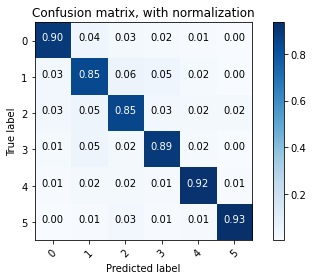

In [55]:
lstm_list=process_test(new_model2,30,train_it,val_it,test_it,0.001,"LSTM_Sector.pt")

## GRU results

Epoch :  5  Train Loss :  0.31991306822769583   Train Acc :  0.8713993329290479   Valid Loss :  0.34698595397724585  Val Acc :  0.8670550847457628
Epoch :  10  Train Loss :  0.26043891365721195   Train Acc :  0.8938371740448757   Valid Loss :  0.3515085705136542  Val Acc :  0.8737893462469734
Epoch :  15  Train Loss :  0.23932874797399478   Train Acc :  0.9019147076702175   Valid Loss :  0.33151362349699787  Val Acc :  0.8722760290556901
Epoch :  20  Train Loss :  0.23284413958075098   Train Acc :  0.9052857346719796   Valid Loss :  0.3299648624875468  Val Acc :  0.8763619854721549
Epoch :  25  Train Loss :  0.22898964815970177   Train Acc :  0.9061362947240752   Valid Loss :  0.3480209954950866  Val Acc :  0.8772699757869249
Epoch :  30  Train Loss :  0.22838902909897738   Train Acc :  0.906344754396604   Valid Loss :  0.33029690654628424  Val Acc :  0.8766646489104116

Time needed for Training :  11.351569219430287

Loss in Testset :  0.33688055933275357   Accuracy in Testset :  0.88

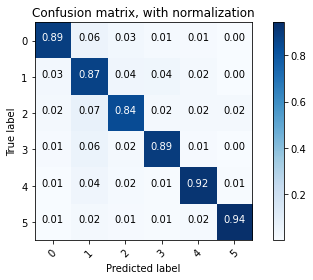

In [56]:
gru_list=process_test(new_model3,30,train_it,val_it,test_it,0.001,"GRU_Sector.pt")